In [1]:
import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy
import scipy.signal
import os, os.path

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb


import sys
start_time = time.time()

/Users/hn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')

import remote_sensing_core as rc
import remote_sensing_plot_core as rcp

data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/test_Aeolus_data/"
raw_dir = "/Users/hn/Documents/01_research_data/remote_sensing/01_NDVI_TS/70_Cloud/00_Eastern_WA_withYear/2Years/"

In [3]:
eleven_colors = ["gray", "lightcoral", "red", "peru",
                 "darkorange", "gold", "olive", "green",
                 "blue", "violet", "deepskyblue"]

indeks = "EVI"
# irrigated_only = 1

given_county = "Yakima"

# jumps = sys.argv[1]
# indeks = sys.argv[2]
# irrigated_only = int(sys.argv[3])
# SF_year = int(sys.argv[4])
# given_county = sys.argv[5]
# regularized = True
SF_year = 2016
sos_thresh = 0.3
eos_thresh = 0.3
minFinderDetla = 0.4

f_name = "01_Regular_filledGap_" + given_county + "_SF_" + str(SF_year) + "_EVI.csv"
raw_f_name = "Eastern_WA_" + str(SF_year) + "_70cloud_selectors.csv"

a_df = pd.read_csv(data_dir + f_name, low_memory=False)
raw_df = pd.read_csv(raw_dir + raw_f_name, low_memory=False)


if 'Date' in a_df.columns:
    if type(a_df.Date.iloc[0]) == str:
        a_df['Date'] = pd.to_datetime(a_df.Date.values).values

a_df = a_df[a_df['county'] == given_county.replace("_", " ")] # Filter Grant
raw_df = raw_df[raw_df['county'] == given_county.replace("_", " ")] # Filter Grant


a_df = rc.filter_out_NASS(a_df) # Toss NASS
a_df = rc.filter_by_lastSurvey(a_df, year = SF_year) # filter by last survey date
a_df['SF_year'] = SF_year
raw_df['SF_year'] = SF_year

if not('DataSrc' in a_df.columns):
    print ("Data source is being set to NA")
    a_df['DataSrc'] = "NA"

if not('CovrCrp' in a_df.columns):
    print ("CovrCrp is being set to NA")
    a_df['CovrCrp'] = "NA"
    
    
if not('DataSrc' in raw_df.columns):
    print ("Data source is being set to NA")
    raw_df['DataSrc'] = "NA"

if not('CovrCrp' in raw_df.columns):
    print ("CovrCrp is being set to NA")
    raw_df['CovrCrp'] = "NA"

CovrCrp is being set to NA
CovrCrp is being set to NA


In [4]:
raw_df.head(2)

,ID,Acres,BSI,county,CropGrp,CropTyp,DataSrc,doy,EVI,ExctAcr,...,PSRI,RtCrpTy,Shap_Ar,Shp_Lng,system_start_time,TRS,image_year,B8,SF_year,CovrCrp
12,48850_WSDA_SF_2016,2,-0.150977,Yakima,Other,developed,wsda,260.0,0.450470,1.689295,...,-0.036312,NaN,6836.333641,362.945835,1.442603e+12,T13R17E25,2015.0,0.26673,2016,NA
13,33409_WSDA_SF_2016,16,-0.096490,Yakima,Other,developed,wsda,260.0,0.499698,15.562098,...,-0.005803,NaN,62977.574553,1174.133704,1.442603e+12,T13R18E16,2015.0,0.36449,2016,NA


In [5]:
a_df = rc.initial_clean(df = a_df, column_to_be_cleaned = indeks)
raw_df = rc.initial_clean(df = raw_df, column_to_be_cleaned = indeks)


In [6]:
if not("human_system_start_time" in raw_df.columns):
    raw_df = rc.add_human_start_time_by_YearDoY(raw_df)


In [7]:
if 'Date' in raw_df.columns:
    if type(raw_df.Date.iloc[0]) == str:
        raw_df['Date'] = pd.to_datetime(raw_df.Date.values).values
else: 
    raw_df['Date'] = pd.to_datetime(raw_df.human_system_start_time.values).values


In [8]:
an_EE_TS = a_df.copy()
print (an_EE_TS.shape)

### List of unique polygons
polygon_list = np.sort(an_EE_TS['ID'].unique())
print ("_____________________________________")
print("len(polygon_list)")
print (len(polygon_list))
print ("_____________________________________")

counter = 0


(990216, 23)
_____________________________________
len(polygon_list)
19416
_____________________________________


In [9]:
a_poly = polygon_list[0] # "33836_WSDA_SF_2018"
          
a_poly in (polygon_list)

True

In [10]:
curr_field_two_years = an_EE_TS[an_EE_TS['ID'] == a_poly].copy()
curr_raw = raw_df[raw_df['ID'] == a_poly].copy()

curr_field_two_years.sort_values(by=['image_year', 'doy'], inplace=True)
curr_raw.sort_values(by=['image_year', 'doy'], inplace=True)

ID = a_poly
plant = curr_field_two_years['CropTyp'].unique()[0]
plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")
plant = plant.replace("__", "_")

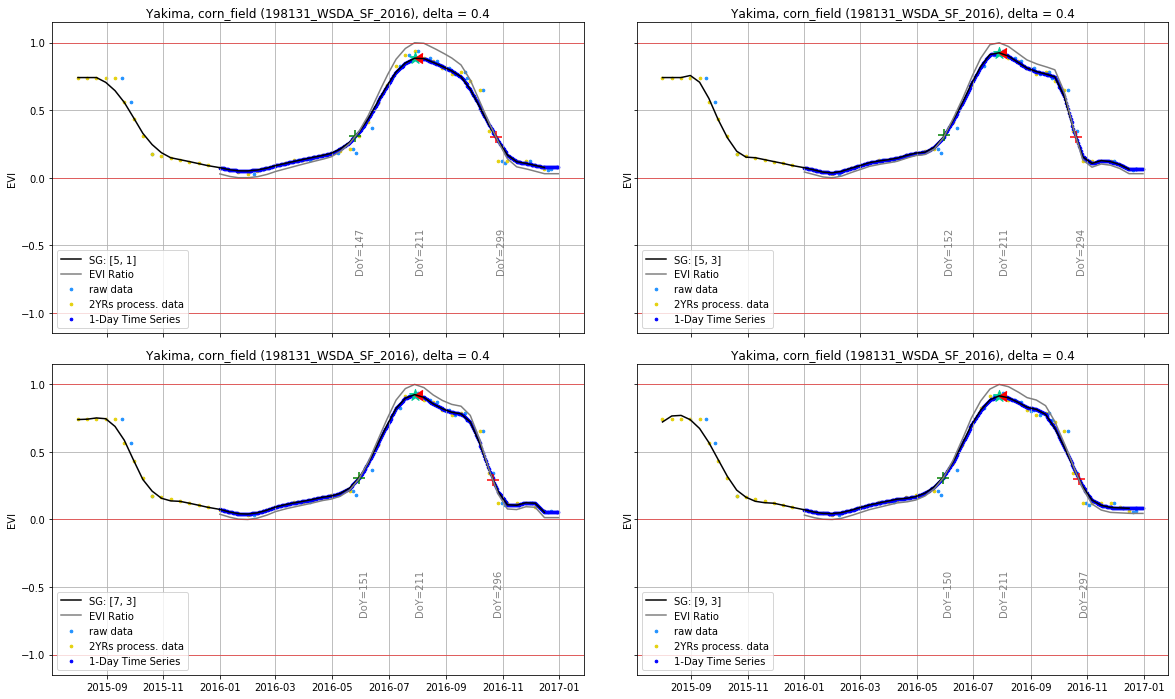

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(20,12),
                sharex='col', sharey='row',
                gridspec_kw={'hspace': 0.1, 'wspace': 0.1});

(ax1, ax2), (ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(twoYears_raw = curr_raw,
                                                           twoYears_regular = curr_field_two_years,
                                                           # dataAB = curr_field_two_years, 
                                                           idx = indeks, 
                                                           SG_params=[5, 1], 
                                                           SFYr = SF_year, ax=ax1, deltA= minFinderDetla,
                                                           onset_cut = sos_thresh, 
                                                           offset_cut = eos_thresh);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(twoYears_raw = curr_raw,
                                                           twoYears_regular = curr_field_two_years,
                                                           # dataAB = curr_field, 
                                                           idx=indeks, SG_params=[5, 3], 
                                                           SFYr=SF_year, ax=ax2, deltA=minFinderDetla,
                                                           onset_cut = sos_thresh, 
                                                           offset_cut = eos_thresh); 

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(twoYears_raw = curr_raw,
                                                           twoYears_regular = curr_field_two_years,
                                                           # dataAB = curr_field, 
                                                           idx = indeks, SG_params=[7, 3],
                                                           SFYr = SF_year, ax=ax3, deltA=minFinderDetla,
                                                           onset_cut = sos_thresh, 
                                                           offset_cut = eos_thresh);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(twoYears_raw = curr_raw,
                                                           twoYears_regular = curr_field_two_years,
                                                           # dataAB = curr_field, 
                                                           idx=indeks, SG_params=[9, 3],
                                                           SFYr=SF_year, ax=ax4, deltA=minFinderDetla,
                                                           onset_cut = sos_thresh, 
                                                           offset_cut = eos_thresh)